In [2]:
from groundedPL.codificacion import ToPropositionalLogic

parser = ToPropositionalLogic()

In [3]:
def complemento(l):
    return l[1:] if l.startswith('-') else '-' + l

def extender_I(I, l):
    var = l[1:] if l.startswith('-') else l
    val = not l.startswith('-')
    I1 = I.copy()
    I1[var] = val
    return I1

def eliminar_literal(S, l):
    lc = complemento(l)
    S1 = []
    for c in S:
        if l in c:
            continue
        nueva = [x for x in c if x != lc]
        S1.append(nueva)
    return S1

def unit_propagate(S, I):
    cambios = True
    while cambios:
        cambios = False
        unitarios = [c[0] for c in S if len(c) == 1]
        for l in unitarios:
            if l[1:] if l.startswith('-') else l in I:
                continue  # Ya asignado
            I = extender_I(I, l)
            S = eliminar_literal(S, l)
            cambios = True
    return S, I

from random import choice
def dpll(S, I):
    S, I = unit_propagate(S, I)

    if [] in S:
        return "Insatisfacible", {}

    if not S:
        return "Satisfacible", I

    # Elegir un literal no asignado
    for c in S:
        for l in c:
            var = l[1:] if l.startswith('-') else l
            if var not in I:
                # Intentar con l = True
                S1 = eliminar_literal(S, l)
                I1 = extender_I(I, l)
                r1, I1 = dpll(S1, I1)
                if r1 == "Satisfacible":
                    return r1, I1

                # Intentar con complemento(l) = True
                lc = complemento(l)
                S2 = eliminar_literal(S, lc)
                I2 = extender_I(I, lc)
                return dpll(S2, I2)
    
    return "Insatisfacible", {}

In [282]:
I = {
    parser.parse("En(0,0,2)"): True,
    parser.parse("Destapada(0,0)"): True
}

In [277]:
from groundedPL.logUtils import LogUtils
from typing import List, Tuple
NUM_FILAS = 7
NUM_COLUMNAS = 7


def barco_h(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos horizontales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales horizontales
    inicio_min = max(0, x - n + 1)
    inicio_max = x
    
    for inicio_x in range(inicio_min, inicio_max + 1):
        casillas = [(inicio_x + i, y) for i in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cx < NUM_FILAS for cx, _ in casillas):
            barcos.append(casillas)
    
    return barcos


def barco_v(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos verticales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales verticales
    inicio_min = max(0, y - n + 1)
    inicio_max = y
    
    for inicio_y in range(inicio_min, inicio_max + 1):
        casillas = [(x, inicio_y + j) for j in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cy < NUM_COLUMNAS for _, cy in casillas):
            barcos.append(casillas)
    
    return barcos

# Regla general: Barcos alineados horizontal o verticalmente Y todas las casillas entre inicio y fin de un barco deben estar ocupadas
def regla_general(I):
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                # Generar todas las configuraciones válidas de barcos que pasan por (x,y)
                configuraciones = []
                
                # Barcos horizontales
                for barco in barco_h(x, y, n):
                    # Construir conjunción: todas las casillas del barco + negaciones externas
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Barcos verticales
                for barco in barco_v(x, y, n):
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Construir la implicación manualmente
                """if configuraciones:
                    antecedente = parser.to_nltk(f"En({x},{y},{n}) & Destapada({x},{y})")
                    consecuente = LogUtils.Otoria(configuraciones)
                    implicacion = f"{antecedente} -> {consecuente}"
                    condiciones.append(parser.to_nltk(implicacion))"""
                if configuraciones:
                    atom_en = parser.parse(f"En({x},{y},{n})")
                    atom_destapada = parser.parse(f"Destapada({x},{y})")

                    if I.get(atom_en, False) and I.get(atom_destapada, False):
                        # Ya tenemos la info, entonces simplemente agregamos la disyunción afirmativa
                        condiciones.append(LogUtils.Otoria(configuraciones))
                    else:
                        # Información parcial no disponible aún → usamos implicación
                        antecedente = parser.to_nltk(f"En({x},{y},{n}) & Destapada({x},{y})")
                        consecuente = LogUtils.Otoria(configuraciones)
                        formula = f"{antecedente} -> {consecuente}"
                        condiciones.append(parser.to_nltk(formula))
    
    return LogUtils.Ytoria(condiciones)

# Regla 4: No superposición de barcos
def crear_regla_4():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                negaciones = []
                for m in range(1, 5):
                    if m != n:
                        negaciones.append(parser.to_nltk(f"-En({x},{y},{m})"))
                antecedente = f"En({x},{y},{n})"    
                consecuente = LogUtils.Ytoria(negaciones)
                implicacion = f"({antecedente}) -> ({consecuente})"
                condiciones.append(parser.to_nltk(implicacion))
    return LogUtils.Ytoria(condiciones)



def reglas(I):
    r = []
    print("Regla 1")
    r.append(regla_general(I))
    print(regla_general(I))

    #print("Regla 4")
    #r.append(crear_regla_4())
    #print(crear_regla_4())

    return LogUtils.Ytoria(r)

reglas(I)



Regla 1
(((En(0,0,1) & Destapada(0,0)) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1) & -En(3,4,1) & -En(3,5,1) & -En(3,6,1) & -En(4,0,1) & -En(4,1,1) & -En(4,2,1) & -En(4,3,1) & -En(4,4,1) & -En(4,5,1) & -En(4,6,1) & -En(5,0,1) & -En(5,1,1) & -En(5,2,1) & -En(5,3,1) & -En(5,4,1) & -En(5,5,1) & -En(5,6,1) & -En(6,0,1) & -En(6,1,1) & -En(6,2,1) & -En(6,3,1) & -En(6,4,1) & -En(6,5,1) & -En(6,6,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3

<AndExpression (((En(0,0,1) & Destapada(0,0)) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1) & -En(3,4,1) & -En(3,5,1) & -En(3,6,1) & -En(4,0,1) & -En(4,1,1) & -En(4,2,1) & -En(4,3,1) & -En(4,4,1) & -En(4,5,1) & -En(4,6,1) & -En(5,0,1) & -En(5,1,1) & -En(5,2,1) & -En(5,3,1) & -En(5,4,1) & -En(5,5,1) & -En(5,6,1) & -En(6,0,1) & -En(6,1,1) & -En(6,2,1) & -En(6,3,1) & -En(6,4,1) & -En(6,5,1) & -En(6,6,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & 

In [278]:
print(barco_h(1, 1, 2))

[[(0, 1), (1, 1)], [(1, 1), (2, 1)]]


In [279]:
print(barco_v(1, 1, 2))

[[(1, 0), (1, 1)], [(1, 1), (1, 2)]]


---

# Visualización de interpretaciones <a class="anchor" id="visual"></a>

([Volver al inicio](#inicio))



In [283]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar_batalla_naval(I: dict):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, NUM_COLUMNAS-0.5)
    ax.set_ylim(-0.5, NUM_FILAS-0.5)
    ax.set_xticks(range(NUM_COLUMNAS))
    ax.set_yticks(range(NUM_FILAS))
    ax.grid(True,linewidth=0.0)
    ax.invert_yaxis()

    colores = {
        'destapada': '#2196F3',  
        'tapada': '#000000',     
        'barco': '#4CAF50'      
    }

    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            # Dibujar casilla base
            rect = patches.Rectangle(
                (y-.5, x-0.5), 1, 1,
                facecolor=colores['tapada'],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)
            
            if parser.parse(f"Destapada({x},{y})") in I and I[parser.parse(f"Destapada({x},{y})")]:
                rect.set_facecolor(colores['destapada'])
                
                # Mostrar información del barco si existe (para cualquier tamaño)
                for n in range(1, 5):
                    if parser.parse(f"En({x},{y},{n})") in I and I[parser.parse(f"En({x},{y},{n})")]:
                        ax.text(
                            y, x, str(n),
                            ha='center', va='center',
                            color='white', fontsize=12,
                            weight='bold'
                        )
                        rect.set_facecolor(colores['barco'])

    plt.title("Batalla Naval - Modo Parcial")
    plt.show()

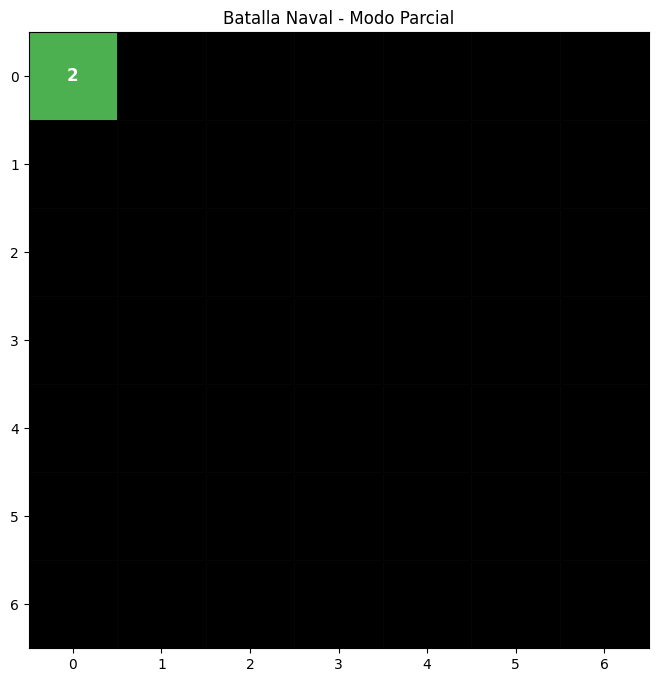

In [284]:
visualizar_batalla_naval(I)

In [287]:

from groundedPL.tseitin import TseitinTransform
from groundedPL.codificacion import Modelo

regla = reglas(I)
modelo = Modelo()
modelo.poblar_con(regla)  
formula_logica = modelo.codificar_lp(regla)


tseitin = TseitinTransform()
clausulas = tseitin.tseitin(formula_logica)

resultado, interpretacion = dpll(clausulas, I)
print("Resultado:", resultado)
print("Interpretación encontrada:", interpretacion)

"""regla = reglas(I)
formula_logica = parser.parse(regla)
tseitin = TseitinTransform()
clausulas = tseitin.tseitin(formula_logica)

resultado, interpretacion = dpll(clausulas, I)
print("Resultado:", resultado)
visualizar_batalla_naval(interpretacion)"""


Regla 1
(((En(0,0,1) & Destapada(0,0)) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1) & -En(3,4,1) & -En(3,5,1) & -En(3,6,1) & -En(4,0,1) & -En(4,1,1) & -En(4,2,1) & -En(4,3,1) & -En(4,4,1) & -En(4,5,1) & -En(4,6,1) & -En(5,0,1) & -En(5,1,1) & -En(5,2,1) & -En(5,3,1) & -En(5,4,1) & -En(5,5,1) & -En(5,6,1) & -En(6,0,1) & -En(6,1,1) & -En(6,2,1) & -En(6,3,1) & -En(6,4,1) & -En(6,5,1) & -En(6,6,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(0,4,1) & -En(0,5,1) & -En(0,6,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(1,4,1) & -En(1,5,1) & -En(1,6,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(2,4,1) & -En(2,5,1) & -En(2,6,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3

'regla = reglas(I)\nformula_logica = parser.parse(regla)\ntseitin = TseitinTransform()\nclausulas = tseitin.tseitin(formula_logica)\n\nresultado, interpretacion = dpll(clausulas, I)\nprint("Resultado:", resultado)\nvisualizar_batalla_naval(interpretacion)'

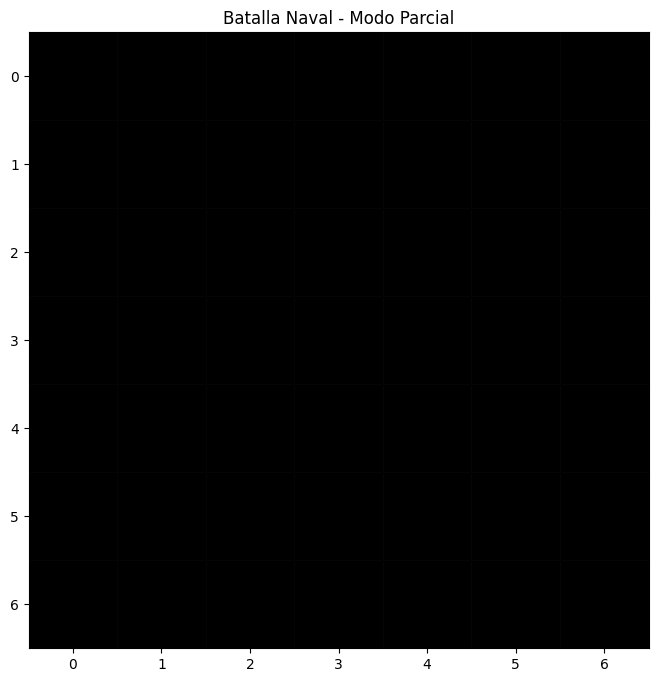

In [289]:
visualizar_batalla_naval(interpretacion)

In [264]:
print("Interpretación Destapada(x,y):")
for x in range(NUM_FILAS):
    for y in range(NUM_COLUMNAS):
        key = parser.parse(f"Destapada({x},{y})")
        if key in I:
            print(f"Destapada({x},{y}): {I[key]}")

print("\nInterpretación En(x,y,n):")
for x in range(NUM_FILAS):
    for y in range(NUM_COLUMNAS):
        for n in range(1, 5):
            key = parser.parse(f"En({x},{y},{n})")
            if key in I and I[key]:
                print(f"En({x},{y},{n}): {I[key]}")

Interpretación Destapada(x,y):
Destapada(0,0): True

Interpretación En(x,y,n):
En(0,0,2): True
